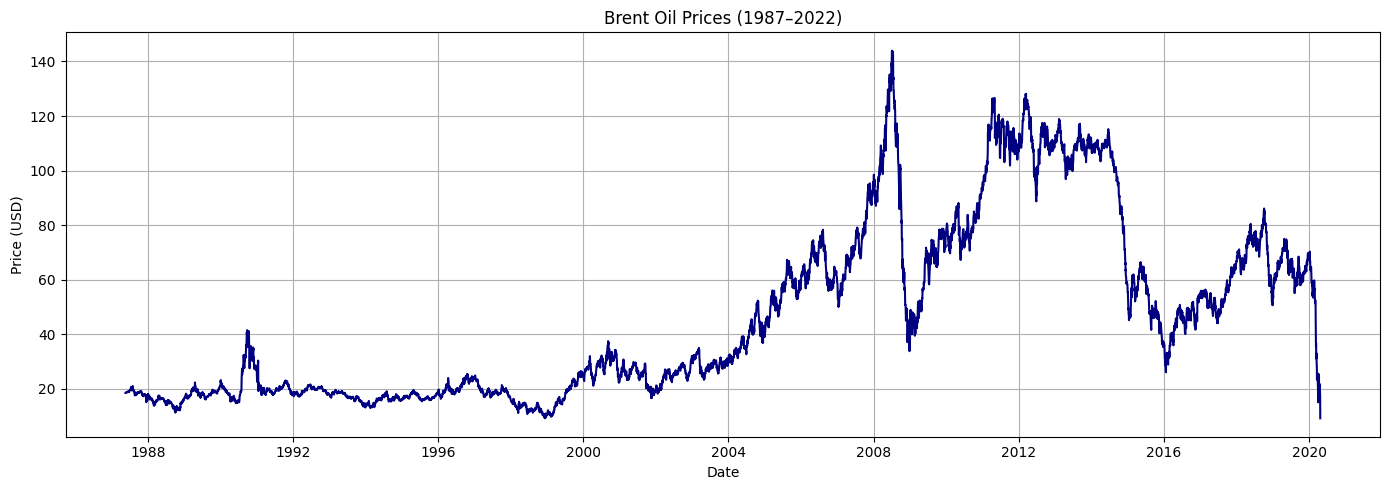

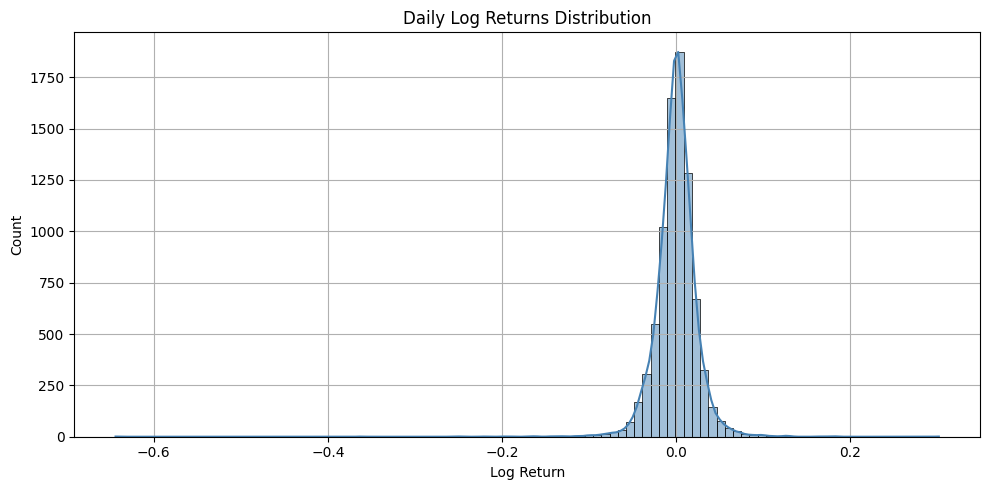

ADF Statistic: -12.6031
p-value: 0.0000
✅ Log returns are stationary


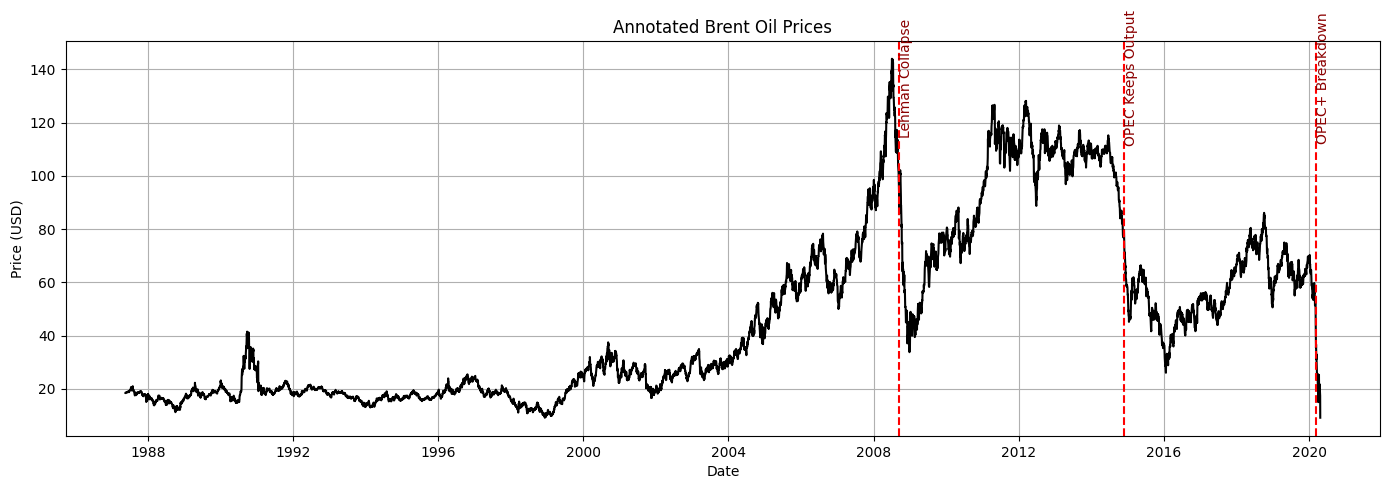

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [tau]
>NUTS: [mu1, mu2, sigma]


Output()

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [ ]:
# 📚 Imports
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import os
import re

# 📁 Paths
RAW_PATH = "../data/raw/BrentOilPrices.csv"
PROCESSED_PATH = "../data/processed/cleaned_data.csv"
os.makedirs("../data/processed", exist_ok=True)

# 🧼 Clean Dates Utility
def clean_date_string(date_str):
    if isinstance(date_str, str):
        return re.sub(r"[^\w\s\-:/]", "", date_str.strip())
    return date_str

def parse_dates(series):
    sample_formats = ["%d-%b-%y", "%Y-%m-%d", "%d/%m/%Y", "%d-%m-%Y"]
    for fmt in sample_formats:
        try:
            return pd.to_datetime(series, format=fmt, errors="coerce")
        except Exception:
            continue
    return pd.to_datetime(series, errors="coerce")  # Fallback

# 🔄 Load & Preprocess Data
df = pd.read_csv(RAW_PATH)
df["Date"] = df["Date"].apply(clean_date_string)
df["Date"] = parse_dates(df["Date"])
df = df.sort_values("Date").reset_index(drop=True)
df["LogReturn"] = np.log(df["Price"]).diff()
df.dropna(inplace=True)
df.to_csv(PROCESSED_PATH, index=False)

# 📊 EDA - Price Trend & Log Return Distribution
plt.figure(figsize=(14,5))
sns.lineplot(x=df["Date"], y=df["Price"], color="navy")
plt.title("Brent Oil Prices (1987–2022)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))
sns.histplot(df["LogReturn"], bins=100, kde=True, color="steelblue")
plt.title("Daily Log Returns Distribution")
plt.xlabel("Log Return")
plt.grid(True)
plt.tight_layout()
plt.show()

# 🧪 Stationarity Check
adf_result = adfuller(df["LogReturn"])
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")
if adf_result[1] < 0.05:
    print("✅ Log returns are stationary")
else:
    print("⚠️ Log returns are non-stationary")

# 📌 Event Annotation
events = [
    ("2008-09-15", "Lehman Collapse"),
    ("2014-11-27", "OPEC Keeps Output"),
    ("2020-03-06", "OPEC+ Breakdown"),
]
plt.figure(figsize=(14,5))
sns.lineplot(x=df["Date"], y=df["Price"], color="black")
for date, label in events:
    d = pd.to_datetime(date)
    plt.axvline(x=d, color='red', linestyle='--')
    plt.text(d, df["Price"].max()*0.95, label, rotation=90, verticalalignment='center', color='darkred')
plt.title("Annotated Brent Oil Prices")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.grid(True)
plt.tight_layout()
plt.show()

# 📐 Bayesian Change Point Model with PyMC
log_returns = df["LogReturn"].values
n = len(log_returns)
idx = np.arange(n)

with pm.Model() as cp_model:
    tau = pm.DiscreteUniform("tau", lower=0, upper=n-1)
    mu1 = pm.Normal("mu1", mu=np.mean(log_returns), sigma=1)
    mu2 = pm.Normal("mu2", mu=np.mean(log_returns), sigma=1)
    sigma = pm.HalfNormal("sigma", sigma=1)
    mu = pm.math.switch(tau >= idx, mu1, mu2)
    pm.Normal("obs", mu=mu, sigma=sigma, observed=log_returns)
    trace = pm.sample(draws=2000, tune=1000, target_accept=0.95)

# 📈 Trace Summary
print(az.summary(trace, hdi_prob=0.95))

# 📊 Posterior Diagnostics
az.plot_trace(trace)
plt.tight_layout()
plt.show()

# 🕵️ Change Point Posterior Plot
tau_samples = trace.posterior["tau"].values.flatten()
plt.figure(figsize=(10,5))
plt.hist(tau_samples, bins=50, color="skyblue", edgecolor="black")
plt.title("Posterior Distribution of Change Point (τ)")
plt.xlabel("Time Index")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()
